In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("ai4i2020.csv")
df["Temp_diff"]=df["Process temperature [K]"]-df["Air temperature [K]"]
df["Power"]=df["Torque [Nm]"]*df["Rotational speed [rpm]"]
features = ['Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]','Temp_diff', 'Power']
labels = ['TWF', 'HDF', 'PWF', 'OSF',
       'RNF']

X = df[features]
Y = df[labels]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

In [51]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',   # handles imbalance
    random_state=42
)

chainRF = ClassifierChain(rf)
chainRF.fit(X_train, Y_train)

# Prediction
y_predRF = chainRF.predict(X_test)

# Evaluation
print("Micro F1 Score:", f1_score(Y_test, y_predRF, average='micro'))
print("Macro F1 Score:", f1_score(Y_test, y_predRF, average='macro'))
print("\nDetailed Classification Report:")
for i, col in enumerate(labels):
    print(f"\nLabel: {col}")
    print(classification_report(Y_test.iloc[:, i], y_predRF[:, i],zero_division=0))

Micro F1 Score: 0.7666666666666667
Macro F1 Score: 0.5284848484848486

Detailed Classification Report:

Label: TWF
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000


Label: HDF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       0.94      0.88      0.91        17

    accuracy                           1.00      2000
   macro avg       0.97      0.94      0.95      2000
weighted avg       1.00      1.00      1.00      2000


Label: PWF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       1.00      1.00      1.00        20

    accuracy                           1.00

In [52]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=6,     # handles imbalance
    n_estimators=300,
    learning_rate=0.05
)

# Classifier Chain model
chain = ClassifierChain(xgb)
chain.fit(X_train, Y_train)

# Predictions
y_pred = chain.predict(X_test)

# Evaluation
print("Micro F1 Score:", f1_score(Y_test, y_pred, average='micro'))
print("Macro F1 Score:", f1_score(Y_test, y_pred, average='macro'))

print("\nDetailed Classification Report:")
for i, col in enumerate(labels):
    print(f"\nLabel: {col}")
    print(classification_report(Y_test.iloc[:, i], y_pred[:, i],zero_division=0))

Micro F1 Score: 0.7716535433070866
Macro F1 Score: 0.5666666666666667

Detailed Classification Report:

Label: TWF
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.25      0.09      0.13        11

    accuracy                           0.99      2000
   macro avg       0.62      0.54      0.57      2000
weighted avg       0.99      0.99      0.99      2000


Label: HDF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       1.00      1.00      1.00        17

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Label: PWF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.95      0.95      0.95        20

    accuracy                           1.00


Confusion Matrix for label: TWF
[[1986    3]
 [  10    1]]


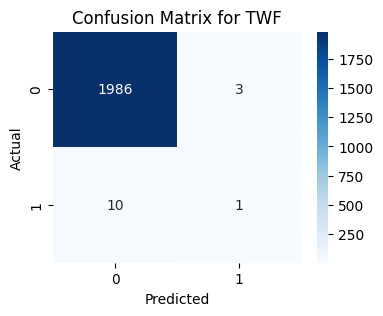


Confusion Matrix for label: HDF
[[1983    0]
 [   0   17]]


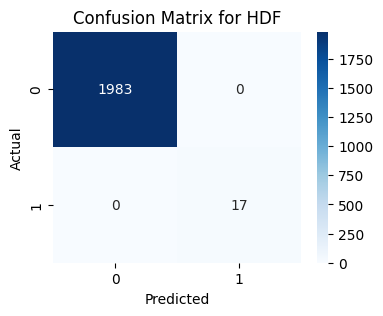


Confusion Matrix for label: PWF
[[1979    1]
 [   1   19]]


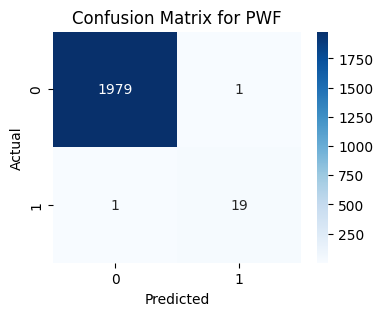


Confusion Matrix for label: OSF
[[1980    2]
 [   6   12]]


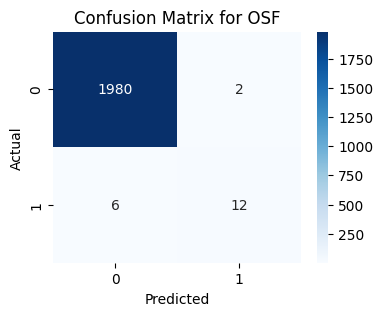


Confusion Matrix for label: RNF
[[1994    0]
 [   6    0]]


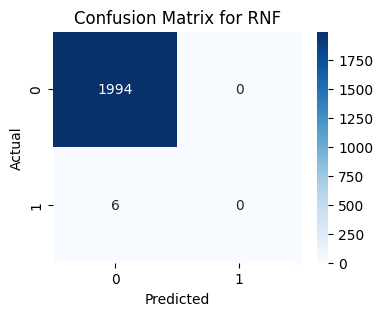

In [53]:
from sklearn.metrics import confusion_matrix

for i, col in enumerate(labels):
    cm = confusion_matrix(Y_test.iloc[:, i], y_pred[:, i])
    print(f"\nConfusion Matrix for label: {col}")
    print(cm)
    
    # Optional: plot heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {col}')
    plt.show()

In [41]:
import shap

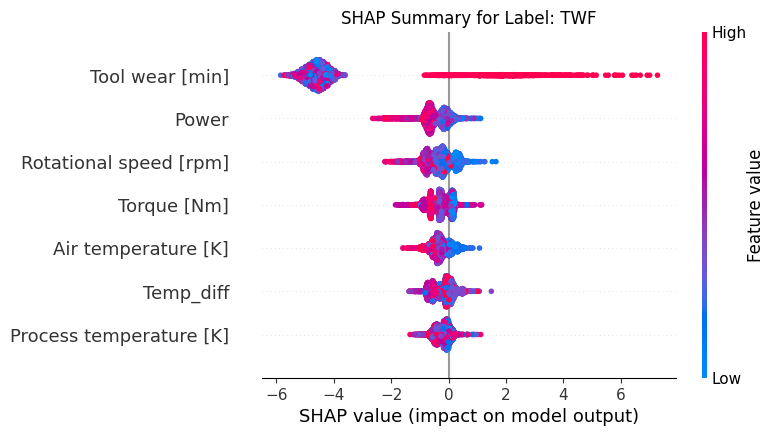

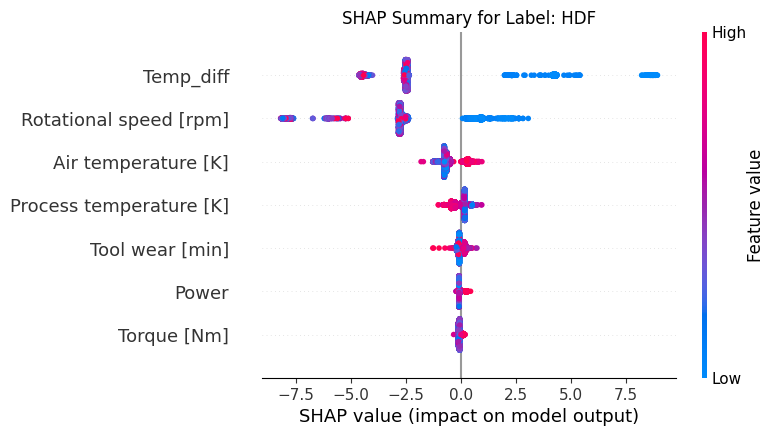

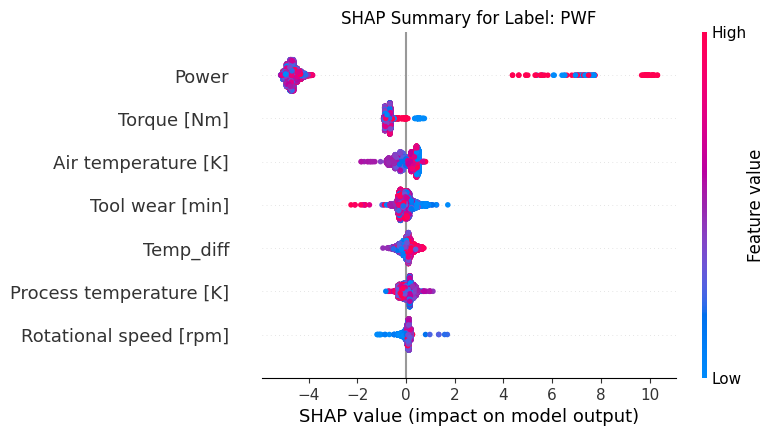

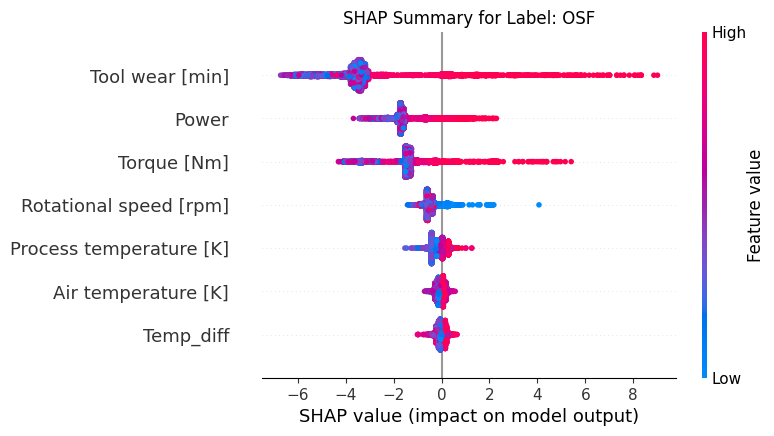

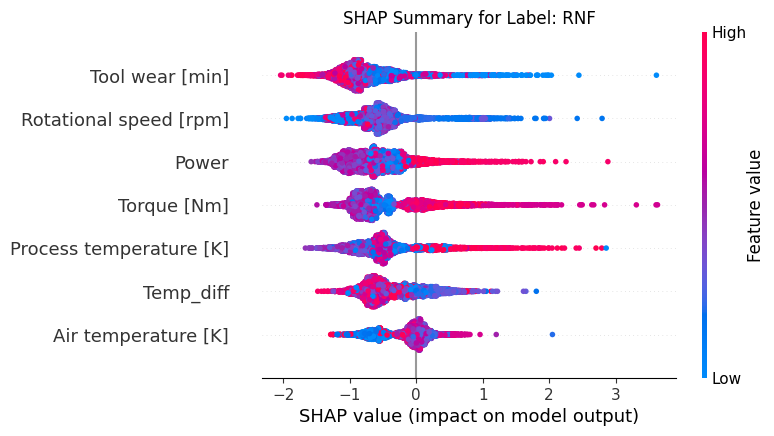

In [54]:
for i, label in enumerate(labels):
    model_i = chain.estimators_[i]

    # reconstruct the training input for ith model
    X_chain = X_train.copy()

    if i > 0:
        prev_labels = Y_train.iloc[:, :i]
        X_chain = np.hstack([X_chain, prev_labels])

    explainer = shap.TreeExplainer(model_i)
    shap_values = explainer.shap_values(X_chain)

    # Only keep SHAP values corresponding to original X features
    shap_values_filtered = shap_values[:, :len(features)]
    X_filtered = X_chain[:, :len(features)]  # decrease SHAP input too

    # Plot only real features
    shap.summary_plot(shap_values_filtered, X_filtered, feature_names=list(features),show=False )
    plt.title(f"SHAP Summary for Label: {label}")
    plt.show()


In [55]:
all_shap = []

for i, label in enumerate(labels):
    model_i = chain.estimators_[i]       # classifier for ith label

    # construct input used by the ith model
    X_chain = X_test.copy()
    if i > 0:
        prev_labels = Y_test.iloc[:, :i]
        X_chain = np.hstack([X_chain, prev_labels])

    explainer = shap.TreeExplainer(model_i)
    shap_values = explainer.shap_values(X_chain)

    # keep only original feature contributions (remove augmented label features)
    shap_values_filtered = shap_values[:, :len(features)]

    # compute mean absolute shap per feature
    mean_abs = np.mean(np.abs(shap_values_filtered), axis=0)

    df = pd.DataFrame({
        'feature': features,
        f'{label}': mean_abs
    })

    all_shap.append(df.set_index('feature'))

# combine all label SHAP importance results
overall = pd.concat(all_shap, axis=1)

# mean importance across labels
overall['mean_importance'] = overall.mean(axis=1)

# sorted final result
overall_sorted = overall.sort_values('mean_importance', ascending=False)
overall_sorted

,TWF,HDF,PWF,OSF,RNF,mean_importance
feature,,,,,,
Tool wear [min],4.336501,0.111486,0.219674,3.420731,0.778285,1.773335
Power,0.453735,0.094769,4.708615,1.546953,0.641355,1.489085
Rotational speed [rpm],0.438721,2.804336,0.104122,0.481348,0.662891,0.898284
Temp_diff,0.292343,2.890150,0.202037,0.146036,0.481345,0.802382
Torque [Nm],0.335279,0.078312,0.725243,1.527997,0.610723,0.655511
Air temperature [K],0.336831,0.643379,0.350490,0.148662,0.277889,0.351450
Process temperature [K],0.246974,0.239888,0.183813,0.225763,0.592963,0.297880
